In [ ]:
import xml.etree.ElementTree as ET
import string
import os  
import re
import pandas as pd

In [ ]:
import pandas as pd
url = 'https://github.com/petermr/CEVOpen/blob/master/classification/machine_learning_miniproject/labelled_sent_ack.csv'
train_data = pd.read_csv('/content/labelled_sent_ack1.csv')


 


train_data = train_data.sample(frac=1).reset_index(drop=True)  #shufffle the dataset

In [ ]:
train_data.head()

,sentences,label
0,['From 50 individual M. piperita L. plants ...,not_acknow
1,The authors would like to express their gratit...,acknow
2,The authors sincerely thank Dr. Seyed Mansour ...,acknow
3,The aim of this study was to determine the fun...,not_acknow
4,['The antibacterial activities of the essentia...,not_acknow


In [ ]:
train_data['category_id'] = train_data['label'].factorize()[0] # factorizing the output into zero and one

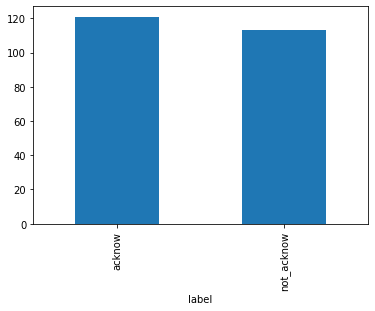

In [ ]:
train_data.groupby('label').category_id.count().plot.bar(ylim=0)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer # term frequency & inverse document frequency (finding important words within text)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(train_data.sentences).toarray()
labels = train_data.category_id

In [ ]:
category_to_id = {'acknow':0, 'not_acknow':1}
id_to_category = {0: 'acknow', 1: 'not_acknow'}

In [ ]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news category) 
from sklearn.feature_selection import chi2
import numpy as np

N = 10  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for Category, category_id in sorted(category_to_id.items()):
  print (f"{category_id} {Category}")
  features_chi2 = chi2(features, labels == category_id)  
  print(features_chi2)                 # Do chi2 analyses of all items in this category
  #index=0 # Possible error
  index=category_id
  indices = np.argsort(features_chi2[index]) 
  print(indices)                                 # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

0 acknow
(array([0.16322683, 0.16322683, 0.16322683, ..., 0.38792336, 0.86921955,
       0.52488895]), array([0.68620286, 0.68620286, 0.68620286, ..., 0.533393  , 0.35117146,
       0.46876361]))
[818 563 860 ... 898 162 259]
# 'acknow':
  . Most correlated unigrams:
       . work
       . leaves
       . university
       . research
       . grateful
       . financial
       . thank
       . support
       . authors
       . collected
  . Most correlated bigrams:
       . blood collected
       . financially supported
       . samples collected
       . scientific research
       . aerial parts
       . authors thank
       . authors grateful
       . like thank
       . authors like
       . financial support
1 not_acknow
(array([0.16322683, 0.16322683, 0.16322683, ..., 0.38792336, 0.86921955,
       0.52488895]), array([0.68620286, 0.68620286, 0.68620286, ..., 0.533393  , 0.35117146,
       0.46876361]))
[259 162 898 ... 198 563 818]
# 'not_acknow':
  . Most correlated unigrams:
  

In [ ]:
##dimension reduction 
from sklearn.manifold import TSNE #low dimensionality plot

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 1)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 

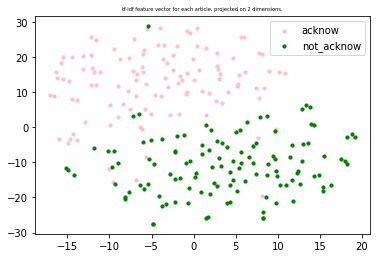

In [ ]:
import matplotlib.pyplot as plt

colors = ['pink', 'green']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=10, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=5))
plt.legend()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score


models = [
    
    RandomForestClassifier(n_estimators=500, max_depth=4, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=3)
]

In [ ]:
CV = 5  # Cross Validate with 5 different folds of 20% data ( 80-20 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

#For each Algorithm 
for model in models:
  model_name = model.__class__.__name__
  # create 5 models with different 20% test sets, and store their accuracies
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

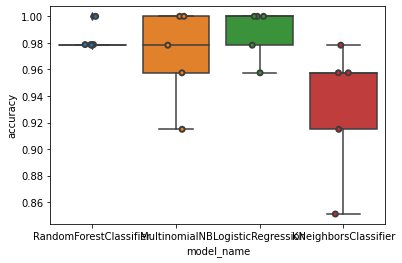

In [ ]:
# Store the entries into the results dataframe and name its columns    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=5, jitter=True, edgecolor="gray", linewidth=2)

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
KNeighborsClassifier      0.931822
LogisticRegression        0.987142
MultinomialNB             0.970120
RandomForestClassifier    0.982886
Name: accuracy, dtype: float64

In [ ]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.978723
1,RandomForestClassifier,1,0.978723
2,RandomForestClassifier,2,0.978723
3,RandomForestClassifier,3,1.000000
4,RandomForestClassifier,4,0.978261
5,MultinomialNB,0,1.000000
6,MultinomialNB,1,0.914894
7,MultinomialNB,2,1.000000
8,MultinomialNB,3,0.957447
9,MultinomialNB,4,0.978261


In [ ]:
from sklearn.model_selection import train_test_split

#model = RandomForestClassifier()
model = MultinomialNB()

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, train_data.index, test_size=0.33, random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [ ]:
category_id_df = train_data[['label', 'category_id']].drop_duplicates().sort_values('category_id')

Text(0.5, 14.09375, 'Predicted')

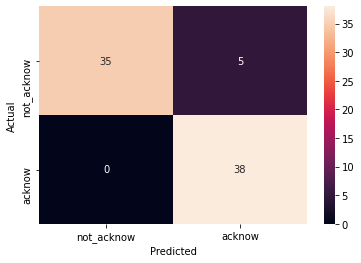

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
#run chi squared

In [ ]:
from IPython.display import display

for predicted in category_id_df.category_id:
   for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(train_data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]['sentences'])
      print('')

'acknow' predicted as 'not_acknow' : 5 examples.


106    IUCN Centre for Mediterranean Cooperation , Ca...
136    Generally, it is assumed that the MVA pathway ...
90     ['The microorganisms were collected from the I...
52     A Cooperation of Toll-like receptor signals in...
40     It constitutes an important step in the develo...
Name: sentences, dtype: object

In [ ]:
model2 = RandomForestClassifier()
model2.fit(features, labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
from IPython.display import display

for predicted in category_id_df.category_id:
   for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(train_data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]['sentences'])
      print('')

'acknow' predicted as 'not_acknow' : 5 examples.


106    IUCN Centre for Mediterranean Cooperation , Ca...
136    Generally, it is assumed that the MVA pathway ...
90     ['The microorganisms were collected from the I...
52     A Cooperation of Toll-like receptor signals in...
40     It constitutes an important step in the develo...
Name: sentences, dtype: object